In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-59-763aa5c6464f>:61: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2693 - loss: 1.9078 - val_accuracy: 0.5208 - val_loss: 1.2584
Epoch 2/30
 1/37 ━━━━━━━━━━━━━━━━━━━━ 33s 924ms/step - accuracy: 0.2500 - loss: 2.0708

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2500 - loss: 2.0708 - val_accuracy: 0.3333 - val_loss: 1.2248
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 75s 936ms/step - accuracy: 0.3880 - loss: 1.3875 - val_accuracy: 0.7500 - val_loss: 1.0133
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5625 - loss: 1.1147 - val_accuracy: 0.5000 - val_loss: 1.3741
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 938ms/step - accuracy: 0.5124 - loss: 1.1588 - val_accuracy: 0.7431 - val_loss: 0.8946
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8125 - loss: 0.8103 - val_accuracy: 0.8333 - val_loss: 0.6908
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 959ms/step - accuracy: 0.6238 - loss: 0.9981 - val_accuracy: 0.7847 - val_loss: 0.8230
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6250 - loss: 0.8910 - val_accuracy: 0.6667 - val_loss: 0.8025
Epoch 9/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 937ms/step - accuracy: 0.6313 - loss: 0.9641 - val_accuracy: 0.7708 - val_lo

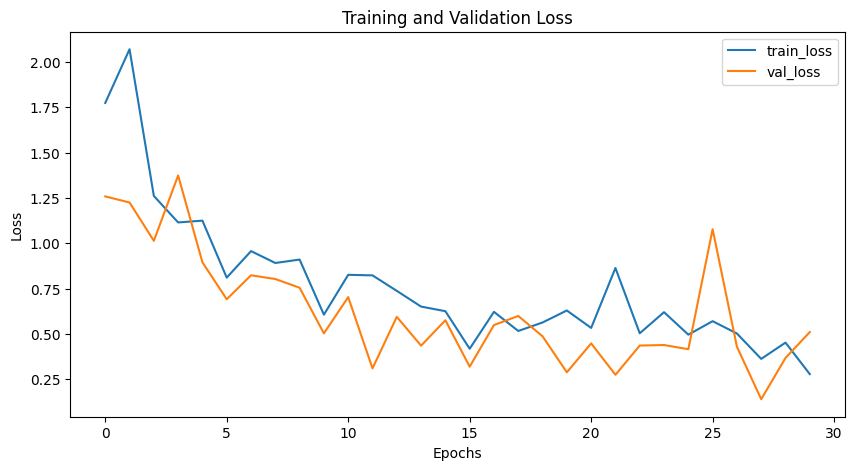

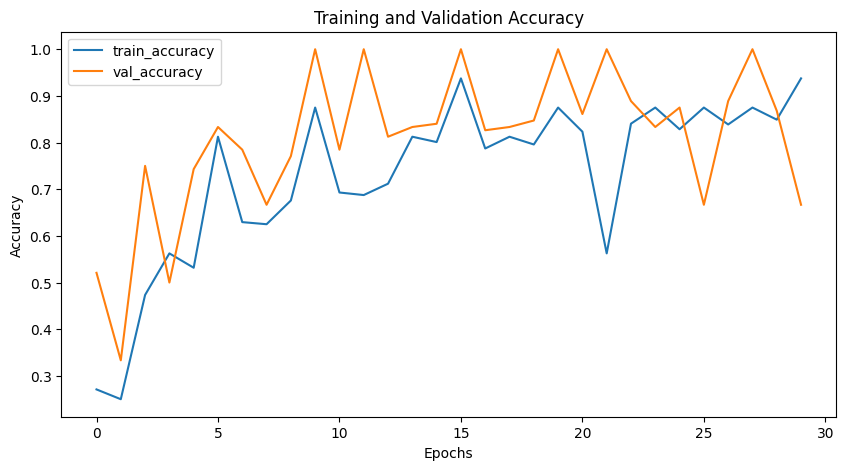

In [59]:
# Import necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import os
import matplotlib.pyplot as plt

# Set up training parameters
INIT_LR = 1e-4
EPOCHS = 30
BS = 16
DIRECTORY = "/content/drive/MyDrive/Deep Learning/Dataset"
CATEGORIES = ["Siti Zubaidah", "Mareta Aliana","Rizky Putri Pratiwi","Nanda Nurahmanita Putri", "Novia Evianti"]

# Load and preprocess dataset
data = []
labels = []
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

# Encode labels
lb = LabelBinarizer()
labels_encoded = lb.fit_transform(labels)

# Convert data and labels to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels_encoded)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

# Assign the split data to train and test variables
trainX, testX, trainY, testY = X_train, X_test, y_train, y_test

# Create data augmentation generator
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Load pre-trained MobileNetV2 without the top layers
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Add custom head to the pre-trained model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CATEGORIES), activation="softmax")(headModel)

# Construct the final model
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze base layers so they aren't updated during training
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Calculate steps_per_epoch and validation_steps
steps_per_epoch = max(len(trainX) // BS, 1)
validation_steps = max(len(testX) // BS, 1)

# Use `.repeat()` to ensure the data is repeated if necessary
train_gen = aug.flow(trainX, trainY, batch_size=BS)
test_gen = aug.flow(testX, testY, batch_size=BS)

# Train the model
H = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS
)

# Save the trained model
model.save("/content/drive/MyDrive/Deep Learning/face_detector1.keras")

# Evaluate the model
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# Plot training loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [60]:
# Import necessary libraries
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # For displaying frames in Colab

def detect_and_predict_classes(frame, faceNet, maskNet):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224), (104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            face = frame[startY:endY, startX:endX]
            if face.size == 0:
                continue

            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)

# Load models
prototxtPath = "/content/drive/MyDrive/Deep Learning/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/Deep Learning/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
maskNet = load_model("/content/drive/MyDrive/Deep Learning/face_detector1.keras")

# Load video file
video_path = "/content/drive/MyDrive/Deep Learning/put.mp4"
cap = cv2.VideoCapture(video_path)

# Define output video settings
output_path = "/content/drive/MyDrive/Deep Learning/output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Process the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (width, height))  # Ensure consistent dimensions
    (locs, preds) = detect_and_predict_classes(frame, faceNet, maskNet)

    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        classes = ["Siti Zubaidah", "Mareta Aliana","Rizky Putri Pratiwi","Nanda Nurahmanita Putri", "Novia Evianti"]
        idx = np.argmax(pred)
        label = f"{classes[idx]}: {pred[idx]*100:.2f}%"
        color = (0, 255, 0) if idx == 0 else (255, 0, 0) if idx == 1 else (0, 0, 255)

        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        cv2.putText(frame, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

    writer.write(frame)  # Write the processed frame to the video

cap.release()
writer.release()

# Convert output video for display in Colab
# Konversi video menggunakan ffmpeg
!ffmpeg -y -i "/content/drive/MyDrive/Deep Learning/output_video.mp4" -vcodec libx264 -f mp4 "/content/drive/MyDrive/Deep Learning/output_video_colab.mp4"


from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    with open(path, "rb") as video_file:
        video_data = b64encode(video_file.read()).decode()
        video_tag = f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{video_data}" type="video/mp4"></video>'
        return HTML(video_tag)

# Tampilkan video
show_video("/content/drive/MyDrive/Deep Learning/output_video_colab.mp4")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━

In [66]:
# Import necessary libraries
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # For displaying frames in Colab

def detect_and_predict_classes(frame, faceNet, maskNet):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224), (104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            face = frame[startY:endY, startX:endX]
            if face.size == 0:
                continue

            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)

# Load models
prototxtPath = "/content/drive/MyDrive/Deep Learning/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/Deep Learning/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
maskNet = load_model("/content/drive/MyDrive/Deep Learning/face_detector1.keras")

# Load video file
video_path = "/content/drive/MyDrive/Deep Learning/ber3.mp4"
cap = cv2.VideoCapture(video_path)

# Define output video settings
output_path = "/content/drive/MyDrive/Deep Learning/output_video1.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Process the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (width, height))  # Ensure consistent dimensions
    (locs, preds) = detect_and_predict_classes(frame, faceNet, maskNet)

    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        classes = ["Siti Zubaidah", "Mareta Aliana","Rizky Putri Pratiwi","Nanda Nurahmanita Putri", "Novia Evianti"]
        idx = np.argmax(pred)
        label = f"{classes[idx]}: {pred[idx]*100:.2f}%"
        color = (0, 255, 0) if idx == 0 else (255, 0, 0) if idx == 1 else (0, 0, 255)

        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        cv2.putText(frame, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

    writer.write(frame)  # Write the processed frame to the video

cap.release()
writer.release()

# Convert output video for display in Colab
# Konversi video menggunakan ffmpeg
!ffmpeg -y -i "/content/drive/MyDrive/Deep Learning/output_video1.mp4" -vcodec libx264 -f mp4 "/content/drive/MyDrive/Deep Learning/output_video_colab1.mp4"


from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    with open(path, "rb") as video_file:
        video_data = b64encode(video_file.read()).decode()
        video_tag = f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{video_data}" type="video/mp4"></video>'
        return HTML(video_tag)

# Tampilkan video
show_video("/content/drive/MyDrive/Deep Learning/output_video_colab1.mp4")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms